# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Import all the necessary Library

In [1]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from Utility import *

%matplotlib inline

## Distortion Correction

### Compute the camera calibration using chessboard images

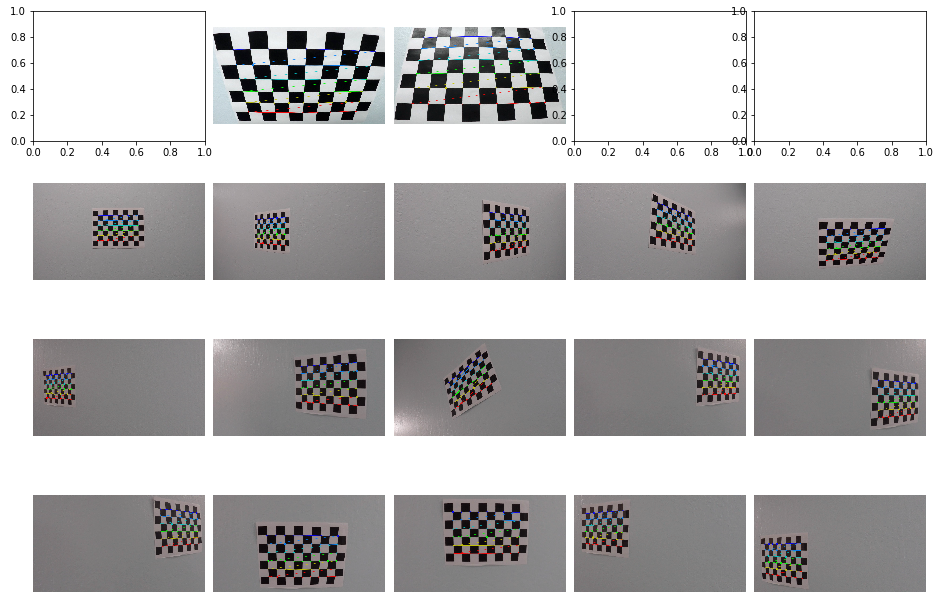

In [2]:
row = 6
column = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros( (row * column, 3), np.float32)
objp[:, :2] = np.mgrid[0:column, 0:row].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(4,5, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.05)
axs = axs.ravel()

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(grayImg, (column,row), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        
        corners2 = cv2.cornerSubPix(grayImg, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (column, row), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)


### Test Undistortion with Chessboard

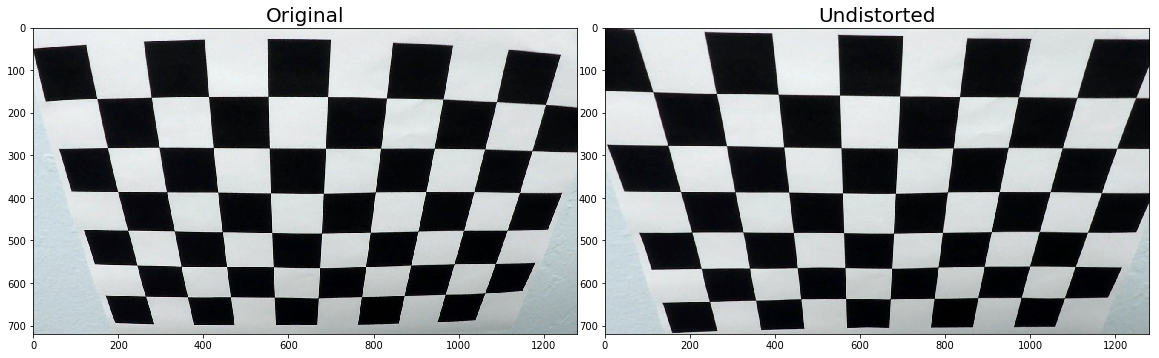

In [3]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration02.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = undistort(img, dist, mtx)

displayResult(img, dst, "Original", "Undistorted", False)


### Test undistortion with Street Image

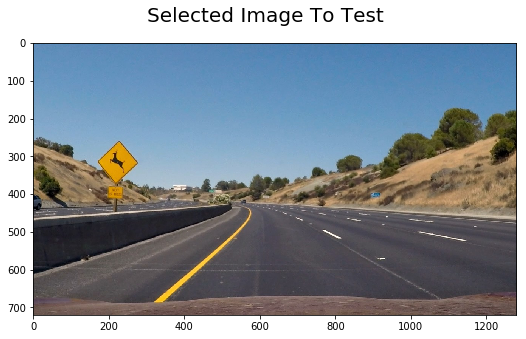

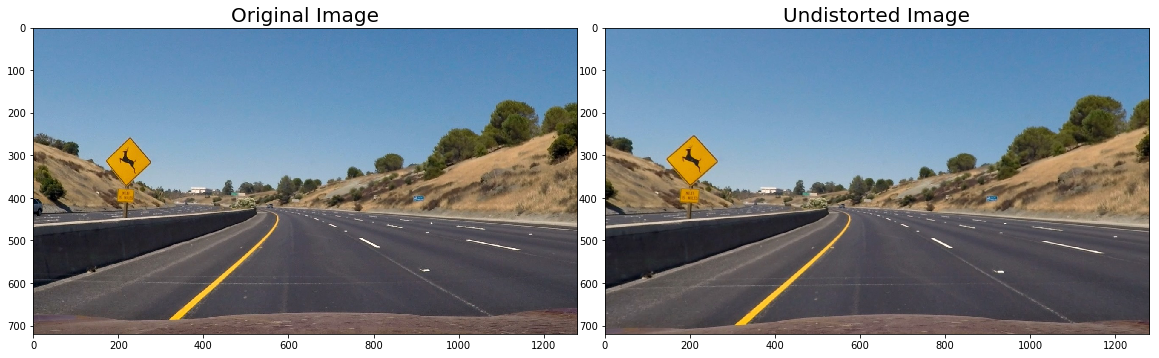

In [4]:
# Choose a test image 
aImg = cv2.imread('./test_images/test2.jpg')
aImg = cv2.cvtColor(aImg, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.suptitle("Selected Image To Test", fontsize=20)
plt.imshow(aImg)

aImg_Undistort = undistort(aImg, dist, mtx)

displayResult(aImg, aImg_Undistort , "Original Image", "Undistorted Image", False )

## Transform

### Perspective Transform

* Perspective
    * Objects appear Smaller the farther away they are from a viewpoint parallel lines seem to converge to a point
    * Perspective to give the right impression of an object's size, depth, and position when viewed from a particular point.
    * Lane looks smaller the farther aways it gets from the camera.
    
* Characterize with Mathematical Perspective
    * in real world coordinates x, y, and z, the greater the magnitude of an objects z coordinate, or distance from the camera, the smaller it will appear in a 2D image
    
* A perspective transform 
    * warps the image and effectively drags points towards or pushes them away from the camera to change the apparent perspective.
    * a lane are easier to perform on a bird's eye view of an image
    * the process of applying a perspective transform will be kind of similar to how we applied undistortion
    
   
* define source and destination points for transform
    * src = np.float32([(575,464), (707,464), (258,682), (1049,682)])	
    * dst = np.float32([(200,0), (width-200,0), (200,hight), (width-200,hight)])

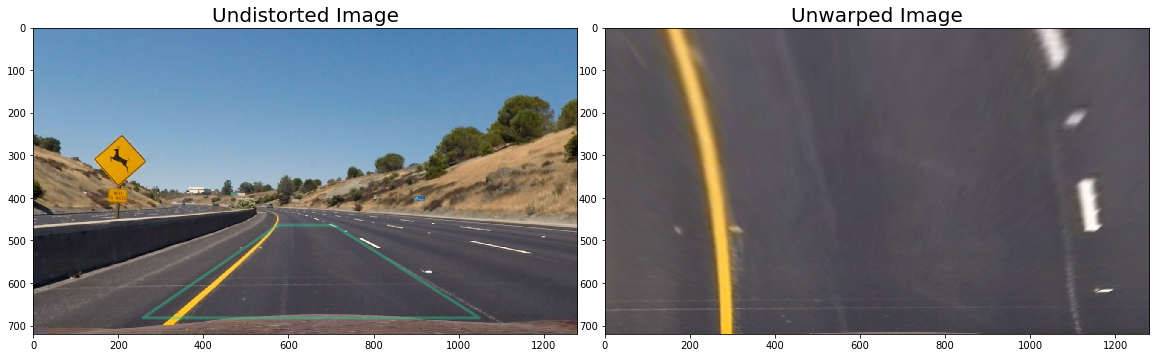

In [5]:
aImg_unwarp, M, Minv = unwarp(aImg_Undistort)

displayResult(aImg_Undistort, aImg_unwarp, 'Undistorted Image', 'Unwarped Image' , True  )

## Canny edge detection algorithm

### Applying Sobel Operator

* The Sobel operator is at the heart of the Canny edge detection algorithm
* Applying the Sobel operator to an image is a way of taking the derivative of the image in the xx or yy direction.
    * Sobel operators with a kernel size of 3 (3 x 3 operator) 
        * Kernel size of 3 is the minimum size, 
        * The kernel size can be any odd number.
        * A larger kernel implies taking the gradient over a larger region of the image, (a smoother gradient).
    * Taking the gradient in the xx direction emphasizes edges closer to vertical. 
    * Taking the gradient in the yy direction emphasizes edges closer to horizontal.    


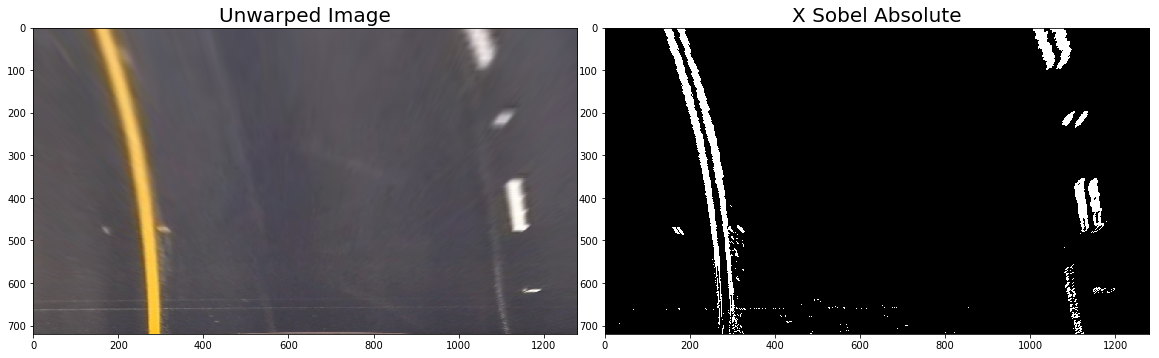

In [6]:
aImg_Sobel = abs_sobel_thresh(aImg_unwarp, orient='x', thresh_min=20, thresh_max=100)

displayResult(aImg_unwarp, aImg_Sobel, 'Unwarped Image', 'X Sobel Absolute', False  )

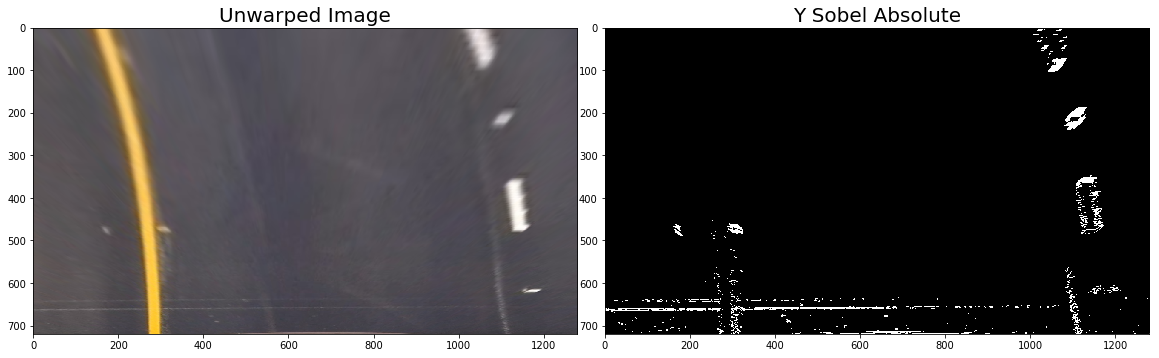

In [7]:
aImg_Sobel = abs_sobel_thresh(aImg_unwarp, orient='y', thresh_min=10, thresh_max=50)

displayResult(aImg_unwarp, aImg_Sobel, 'Unwarped Image', 'Y Sobel Absolute', False  )

### Magnitude of the Gradient

* Gradient magnitude is at the heart of Canny edge detection
    * Canny works well for picking up all edges.
    * we're interested only in edges of a particular orientation.
    * we will explore the direction, or orientation, of the gradient.
    
    
* The magnitude, or absolute value, of the gradient is just the square root of the squares of the individual x and y gradients.
    * The size of the region in the image over which you'll be taking the gradient. 
    * You can modify the kernel size for the Sobel operator to change the size of this region. 
        * Taking the gradient over larger regions can smooth over noisy intensity fluctuations on small scales. 
        * The default Sobel kernel size is 3, define a new function that takes kernel size as a parameter.
        * the kernel size should be an odd number.

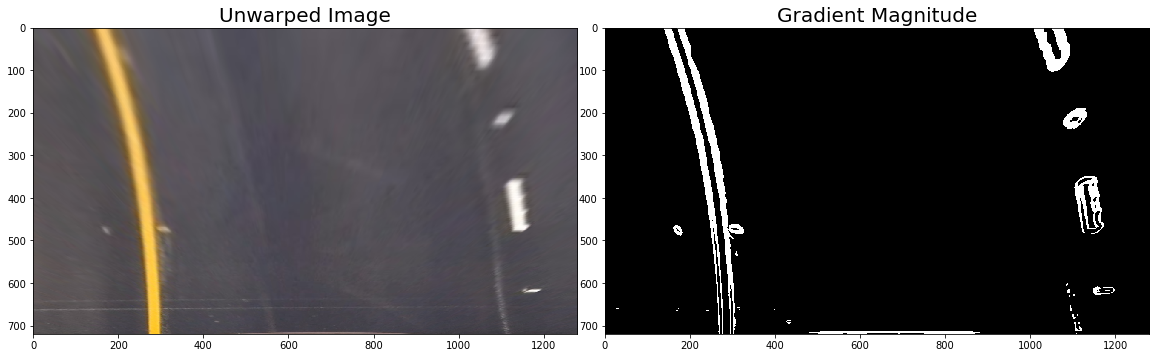

In [8]:
aImg_MagBinary = mag_thresh(aImg_unwarp, sobel_kernel=25, mag_thresh=(30, 100))

displayResult(aImg_unwarp, aImg_MagBinary, 'Unwarped Image', 'Gradient Magnitude', False  )

### Direction of the Gradient

* The direction of the gradient
    * the inverse tangent (arctangent) of the yy gradient divided by the xx gradient:
    * arctan{(sobel_y/sobel_x)}
    
* Each pixel of the resulting image contains a value for the angle of the gradient away from horizontal in units of radians
    (covering a range of −π/2 to π/2.) 
    * An orientation of 0 implies a vertical line
    * orientations of {+/-} π/2 imply horizontal lines

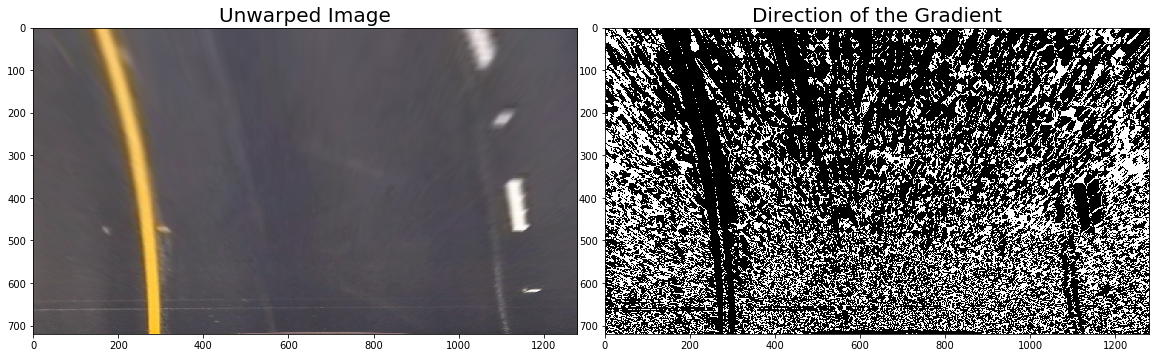

In [9]:
dir_binary = dir_threshold(aImg_unwarp, sobel_kernel=15, thresh=(0.7, 1.3))

displayResult(aImg_unwarp, dir_binary, 'Unwarped Image', 'Direction of the Gradient' , False )

### Magnitude & Direction of the Gradient

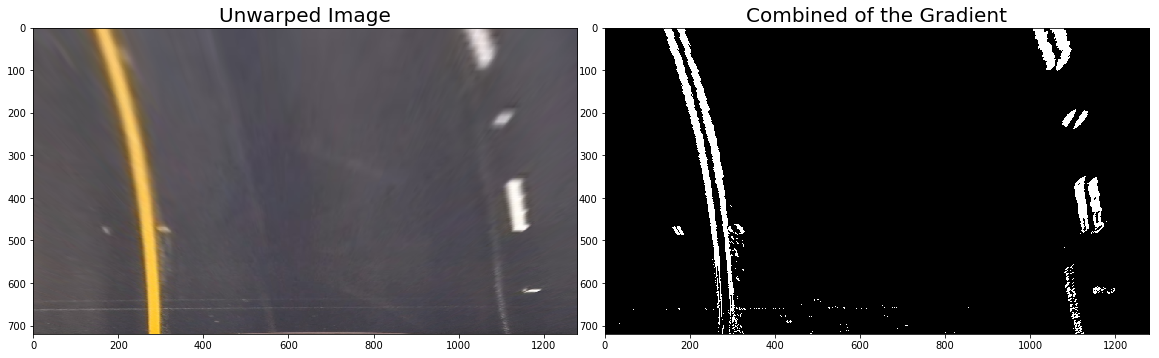

In [10]:
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(aImg_unwarp, orient='x', thresh_min=20, thresh_max=100)
#grady = abs_sobel_thresh(aImg_unwarp, orient='y', thresh_min=10, thresh_max=50)
mag_binary = mag_thresh(aImg_unwarp, sobel_kernel=25, mag_thresh=(30, 100))
dir_binary = dir_threshold(aImg_unwarp, sobel_kernel=15, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1

displayResult(aImg_unwarp, combined, 'Unwarped Image', 'Combined of the Gradient' , False )

## Color Spaces

### HLS and Color Thresholds

* A color space 
    * specific organization of colors
    * color spaces provide a way to categorize colors and represent them in digital images.

* Types of Color Space
    * RGB 
        * Red - Green - Blue color space.
        * matplotlib.image.imread() will give a RGB image.
    
    * BGR 
        * Blue - Green - Red color space
        * Using OpenCV cv2.imread() will give a BGR image.
        
    * HSV 
        * Hue, Saturation, and Value
    * HLS
        * Hue, Lightness, and Saturation
        
* Basic Color
    * Hue
        * the value that represents color independent of any change in brightness. 
        * if you imagine a basic red paint color, then add some white to it or some black to make that color lighter or darker?
            * the underlying color remains the same and the hue for all of these colors will be the same.
            
    * Lightness and Value 
        * different ways to measure the relative lightness or darkness of a color. 
        * For example, a dark red will have a similar hue but much lower value for lightness than a light red.
        
    * Saturation
        * saturation is a measurement of colorfulness. 
        * As colors get lighter and closer to white, they have a lower saturation value
        * whereas colors that are the most intense, like a bright primary color (imagine a bright red, blue, or yellow), have a high saturation value. 

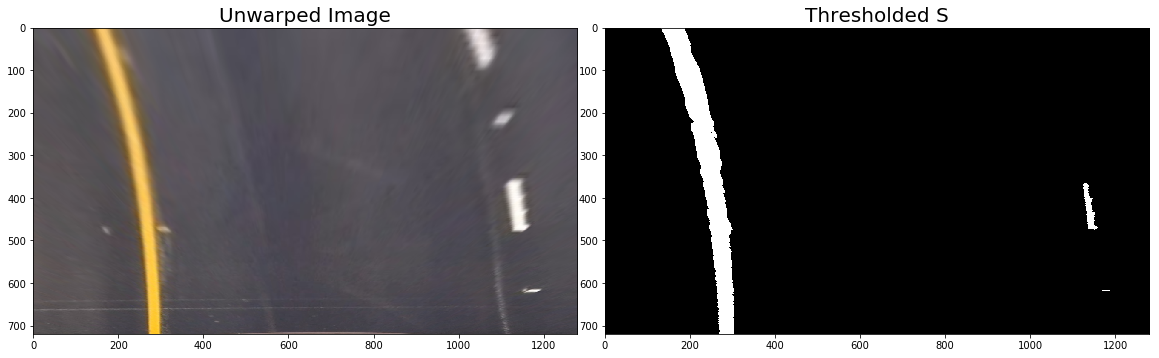

In [11]:
aImg_HLS = hls_select(aImg_unwarp, thresh=(90, 255))

displayResult(aImg_unwarp, aImg_HLS, 'Unwarped Image', 'Thresholded S' , False )